
####

In [48]:

##----------
# Data Missing via LLM
##----------

from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Config  
from transformers import get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split, RandomSampler, SequentialSampler
import pandas as pd
from tqdm.auto import tqdm
import random
import datetime
import time


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model_name = "gpt2-medium"  # ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
configuration = GPT2Config.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration) 
# model_path = r'C:\Users\ericl\Adapters\FT_GPT\model' #tu directorio
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)

input_sequence = "Toy Story (1995): 1.5"
input_ids = tokenizer.encode(input_sequence, return_tensors='pt')
model = model.to(device)
sample_outputs = model.generate(
                              input_ids.to(device),
                              do_sample = True,
                              max_length = 100,
                              top_k = 50,
                              top_p = 0.85,
                              num_return_sequences = 3
)



cuda


c:\Users\ericl\Adapters\.env\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ericl\.cache\huggingface\hub\models--gpt2-medium. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your inp

In [50]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [51]:
print("Output:\n" + 100 * '-')
for i, sample_outputs in enumerate(sample_outputs):
    print("{}: {}...".format(i, tokenizer.decode(sample_outputs, skip_special_tokens = True)))
    print('  ---')

Output:
----------------------------------------------------------------------------------------------------
0: Toy Story (1995): 1.5/5, Rotten Tomatoes 4.0

3. Toy Story 2 (1995): 1.3/5, Rotten Tomatoes 4.0

4. Toy Story 3 (1996): 1.2/5, Rotten Tomatoes 3.5

5. Toy Story 4 (1997): 1.1/5, Rotten Tomatoes 4.0

Toy Story (1996): 1.3/5,...
  ---
1: Toy Story (1995): 1.5 million

Disney Pixar (2009): 2.2 million

Disney Pixar (2010): 2.3 million

Disney Pixar (2011): 3.7 million

Disney Pixar (2012): 4.4 million

Disney Pixar (2013): 4.5 million

Disney Pixar (2014): 4.9 million

Disney Pixar (2015): 4.9 million

Disney Pixar (2016): 5.5 million

Disney...
  ---
2: Toy Story (1995): 1.5 (the first one was better), 3.5 (better than Cars), 4 (the last one was better), 5.5 (same as Cars), 6.5 (better than Cars, though not nearly as good as Toy Story), 7.5 (better than Toy Story, but not nearly as good as Toy Story), 8.5 (same as Toy Story), 9.5 (better than Toy Story, but not nearly as good a

-----------
## Dataset
-----------

In [ ]:
import zipfile

path_movie = r'C:\Users\ericl\Adapters\FT_GPT\data\movie.csv.zip'
path_rating = r'C:\Users\ericl\Adapters\FT_GPT\data\rating.csv.zip'

extract_dir = r'C:\Users\ericl\Adapters\FT_GPT\data'

with zipfile.ZipFile(path_movie, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

with zipfile.ZipFile(path_rating, 'r') as zip_ref:
    zip_ref.extractall(extract_dir) 

In [52]:
import pandas as pd 

path_movie = r'C:\Users\ericl\Adapters\FT_GPT\data\movie.csv'
path_rating = r'C:\Users\ericl\Adapters\FT_GPT\data\rating.csv'

df_movies = pd.read_csv(path_movie)
df_ratings = pd.read_csv(path_rating)

df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [53]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [28]:
print(f'Shape of data_movie: {df_movies.shape}')
print(f'Shape of data_ratings: {df_ratings.shape}')

Shape of data_movie: (27278, 3)
Shape of data_ratings: (20000263, 4)


In [29]:
# clean the dataset 
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [30]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [54]:
df_ratings['userId'].nunique()

138493

In [32]:

def extract_user_data(df, user_id):
    """
    Extrae las filas de un DataFrame correspondientes a un userId.
    """
    new_dataframe = df[df['userId'] == user_id].copy()
    return new_dataframe

df_user = extract_user_data(df_ratings, 1)
print(f'Shape of data_user_1: {df_user.shape}')


Shape of data_user_1: (175, 4)


In [33]:
df_ratings['userId'].value_counts().idxmax()

np.int64(118205)

In [55]:
values = df_ratings['userId'].value_counts()
filtered_users = values[(values >= 500) & (values <= 1000)]
filtered_users

userId
102262    1000
101963    1000
28239     1000
26640     1000
136301    1000
          ... 
28630      500
98091      500
79734      500
47865      500
36007      500
Name: count, Length: 5607, dtype: int64

In [56]:
df_user = extract_user_data(df_ratings, 102262)
print(f'Shape of df_user: {df_user.shape}')

Shape of df_user: (1000, 4)


In [36]:
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'])

min_date = df_ratings['timestamp'].min()
max_date = df_ratings['timestamp'].max()

print(f"La fecha más antigua es: {min_date}")
print(f"La fecha más reciente es: {max_date}")
print(f"El rango de fechas es de {max_date - min_date}.")

La fecha más antigua es: 1995-01-09 11:46:44
La fecha más reciente es: 2015-03-31 06:40:02
El rango de fechas es de 7385 days 18:53:18.


In [ ]:

# timestamps_by_user = {}
# for user_id, timestamp in zip(df_ratings['userId'], pd.to_datetime(df_ratings['timestamp'])):
#     if user_id not in timestamps_by_user:
#         timestamps_by_user[user_id] = {'min': timestamp, 'max': timestamp}
#     else:
#         timestamps_by_user[user_id]['min'] = min(timestamps_by_user[user_id]['min'], timestamp)
#         timestamps_by_user[user_id]['max'] = max(timestamps_by_user[user_id]['max'], timestamp)

# # Calcular el rango total de fechas en el dataset
# overall_min = min(user['min'] for user in timestamps_by_user.values())
# overall_max = max(user['max'] for user in timestamps_by_user.values())

# print(f"La fecha más antigua en el dataset es: {overall_min}")
# print(f"La fecha más reciente en el dataset es: {overall_max}")
# print(f"El rango de fechas es de {overall_max - overall_min}.")


La fecha más antigua en el dataset es: 1995-01-09 11:46:44
La fecha más reciente en el dataset es: 2015-03-31 06:40:02
El rango de fechas es de 7385 days 18:53:18.


In [57]:
df_user = df_user.merge(df_movies[['movieId', 'title']], on='movieId', how='left')
df_user = df_user.drop(['movieId', 'timestamp'], axis=1)
df_user


,userId,rating,title
0,102262,3.0,Toy Story (1995)
1,102262,2.0,Jumanji (1995)
2,102262,3.5,GoldenEye (1995)
3,102262,3.0,Casino (1995)
4,102262,3.5,Four Rooms (1995)
...,...,...,...
995,102262,4.5,"Incredibles, The (2004)"
996,102262,1.5,Blade: Trinity (2004)
997,102262,2.0,Fire in the Sky (1993)
998,102262,1.0,Elektra (2005)


In [58]:
df_user['title'] = df_user['title'].fillna('').astype(str)
df_user['rating'] = df_user['rating'].astype(str)
df_user.dtypes

userId     int64
rating    object
title     object
dtype: object

In [90]:
df_user.reset_index(drop=True, inplace=True)

def form_string(rating,title):
    s = f"<start>title: {title.strip()}. " \
        f"rating: {rating.strip()}<end>"
    return s

data = df_user.apply(lambda x: form_string(x['rating'],
    x['title']), axis=1).to_list()

data[3]

'<start>title: Casino (1995). rating: 3.0<end>'

In [91]:
# tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained(model_name, 
                                              bos_token="<star>",
                                              eos_token="<end>",
                                              unk_token="<unk>",
                                              pad_token="<pad>")
 

In [92]:
vocab_list = sorted(tokenizer.vocab.items(), key=lambda x:x[1])

In [46]:
# print("The max model length is {} for this model".format(tokenizer.model_max_length))
# print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
# print("The beginning of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
# print("The unknown token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.unk_token_id), tokenizer.unk_token_id))
# print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model
The end of sequence token <endoftext> has the id 50258
The beginning of sequence token <startoftext> has the id 50257
The unknown token <unk> has the id 50259
The padding token <pad> has the id 50260


PyTorch Dataset

In [95]:
batch_size = 2
max_length = 50

# '<|startoftext|>title: Casino (1995). rating: 3.0<|endoftext|>'

def extract_string(review):
    str = review.replace('<start>', '').replace('<end>', '')
    rat_pos = str.find('rating: ')
    title = str[len('title: '): rat_pos-1]
    rating = str[rat_pos+len('rating: '):]
    return title, rating

# pythorch dataset
class ReviewDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.input_ids = []
        self.attn_masks = []
        self.origin_title = []
        self.origin_rating = []

        for critica in data:
            encodings = tokenizer.encode_plus(critica,
                                              truncation=True,
                                              padding='max_length',
                                              max_length=max_length,
                                              return_tensors='pt'       # 
                                             )
            self.input_ids.append(torch.squeeze(encodings['input_ids'],0))
            # attention_mask tells model not to incorporate these PAD tokens into its interpretation of the sentence
            self.attn_masks.append(torch.squeeze(encodings['attention_mask'],0))
            title, rating = extract_string(critica)
            self.origin_title.append(title)
            self.origin_rating.append(rating)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.input_ids[idx], self.attn_masks[idx], self.origin_title[idx], self.origin_rating[idx]


In [96]:
dataset = ReviewDataset(data, tokenizer)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} muestras de entrenamiento'.format(train_size))
print('{:>5,} muestras de validacion'.format(val_size))

  900 muestras de entrenamiento
  100 muestras de validacion


In [70]:
print(f"dataset size {dataset.__len__()}")
print(f"dataset[0]: \n  input_ids: {dataset[0][0]}\n  attn_masks: {dataset[0][1]}")

dataset size 1000
dataset[0]: 
  input_ids: tensor([   27,  9688,    29,  7839,    25, 10977,  8362,   357, 21908,   737,
         7955,    25,   513,    13,    15, 50258, 50260, 50260, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260,
        50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260, 50260])
  attn_masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

Dataloader 

In [71]:
train_loader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size 
        )

val_loader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size 
        )

In [72]:
configuration = GPT2Config.from_pretrained(model_name, output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)
model = model.to(device)
print(f"Weight shape {model.transformer.wte.weight.shape}")
model.resize_token_embeddings(len(tokenizer))
print(f"Number of tokens: {len(tokenizer)}")
seed_val = 42
random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Weight shape torch.Size([50257, 1024])
Number of tokens: 50261


In [73]:
word_embeddings = model.transformer.wte.weight # Word Token Embeddings
print(word_embeddings.shape)

torch.Size([50261, 1024])


In [97]:
epochs = 3
learning_rate = 2e-5
warmup_steps = 1e2
epsilon = 1e-8
# optim = Adam(model.parameters(), lr=5e-5)
optim = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


# Total number of training steps is [number of batches] x [number of epochs]. 
# # (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler. This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optim,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)


##  Train 

In [ ]:
def infer(prompt):
    input = f"<|star|>title: {prompt.strip()}"
    input = tokenizer(input, return_tensors="pt")
    input_ids      = input["input_ids"]
    attention_mask = input["attention_mask"]

    output = model.generate(input_ids.to(device),
                            attention_mask=attention_mask.to(device),
                            max_new_tokens=max_length,
                            # temperature = 0.5,
                            do_sample = True, top_k = 50, top_p = 0.85)
                            # num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
    output = tokenizer.decode(output[0], skip_special_tokens=True)
    return output

total_t0 = time.time()

training_stats = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()  # `train` just changes the *mode* (train vs. eval), it doesn't *perform* the training.

    for step, batch in enumerate(train_loader):     # step from enumerate() = number of batches

        b_input_ids = batch[0].to(device)   # tokens (of multiple documents in a batch)
        b_labels    = batch[0].to(device)
        b_masks     = batch[1].to(device)   # mask of [1] for a real word, [0] for a pad

        model.zero_grad()
        # loss = model(X.to(device), attention_mask=a.to(device), labels=X.to(device)).loss
        outputs = model(  input_ids = b_input_ids,
                          labels = b_labels,
                          attention_mask = b_masks,
                          token_type_ids = None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % 100 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_loader), batch_loss, elapsed))

            model.eval()

            sample_output = infer("")
            print(sample_output)

            # `train` just changes the *mode* (train vs. eval), it doesn't *perform* the training.
            model.train()

        loss.backward()
        optim.step()
        scheduler.step()

    # Calculate the average loss over all the batches.
    avg_train_loss = total_train_loss / len(train_loader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_loader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(input_ids = b_input_ids,
                             attention_mask = b_masks,
                             labels = b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(val_loader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   100  of    450. Loss: 7.612429618835449.   Elapsed: 0:03:17.
<|star|>title: 信仰貴两个时间 (1998). rating: 1.5 The only one in the bunch, but it's not the worst one either. This one's for the love of god, this guy's got to be like 50+ years older than the director. That said, when we first meet him, he's a total shit-bag, and this is one of his best scenes. He's clearly the worst one in the whole movie,


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   200  of    450. Loss: 0.5569599270820618.   Elapsed: 0:06:33.
<|star|>title: !!!, The (2002). rating: 2.0etheless Tayyip�� YPG,侍��侍侍侍侍侍侍侍侍侍侍�


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   300  of    450. Loss: 0.2574264705181122.   Elapsed: 0:09:49.
<|star|>title: 〜太陽の花 (Yamakuni no Yūshiki no Namida) (1997). rating: 2.5CLASSIFIEDCLASSIFIEDCLASSIFIEDethelessCLASSIFIEDCLASSIFIED


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   400  of    450. Loss: 0.24665144085884094.   Elapsed: 0:13:04.
<|star|>title: ???????? (1999). rating: 2.0

  Average training loss: 3.23
  Training epoch took: 0:14:41

Running Validation...
  Validation Loss: 0.25
  Validation took: 0:00:17

======== Epoch 2 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   100  of    450. Loss: 0.3840624988079071.   Elapsed: 0:03:36.
<|star|>title: 主主女 (Pinyin: tóō-shēng) (1994). rating: 3.5


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   200  of    450. Loss: 0.2317909598350525.   Elapsed: 0:07:13.
<|star|>title: 『Kong: Skull Island』 (1998). rating: 2.0


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   300  of    450. Loss: 0.16947543621063232.   Elapsed: 0:10:50.
<|star|>title: 『Tale of the Tapegrapher: The Life of a Legend (1988). rating: 1.0


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   400  of    450. Loss: 0.18915608525276184.   Elapsed: 0:14:27.
<|star|>title: ????????? (1995). rating: 2.5

  Average training loss: 0.21
  Training epoch took: 0:16:14

Running Validation...
  Validation Loss: 0.23
  Validation took: 0:00:21

======== Epoch 3 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   100  of    450. Loss: 0.23092423379421234.   Elapsed: 0:03:38.
<|star|>title: ??????? (1999). rating: 3.0


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   200  of    450. Loss: 0.15605780482292175.   Elapsed: 0:07:20.
<|star|>title: スーパーマング (サノーマーグ) (1995). rating: 3.0


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   300  of    450. Loss: 0.16851331293582916.   Elapsed: 0:10:59.
<|star|>title: クロスペ (Kuruushuu) (1953). rating: 3.0


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  Batch   400  of    450. Loss: 0.19121509790420532.   Elapsed: 0:14:37.
<|star|>title: スケット (Sakekuraite) (1988). rating: 3.0

  Average training loss: 0.18
  Training epoch took: 0:16:23

Running Validation...
  Validation Loss: 0.23
  Validation took: 0:00:22

Training complete!
Total training took 0:48:18 (h:mm:ss)


In [80]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.229765,0.250550,0:14:41,0:00:17
2,0.210052,0.229956,0:16:14,0:00:21
3,0.182018,0.230754,0:16:23,0:00:22


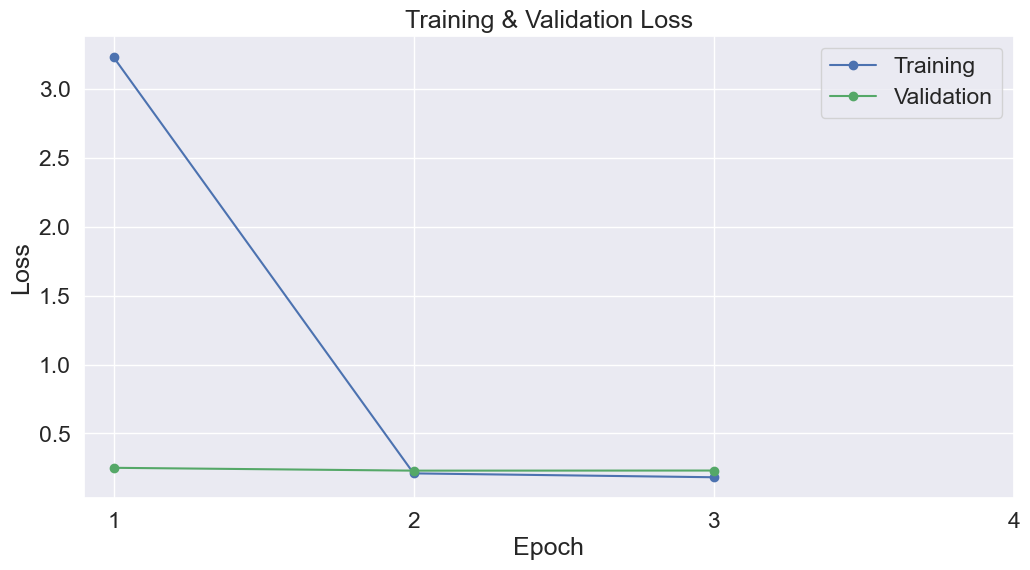

In [82]:
# Use plot styling from seaborn.
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [88]:
print(infer('Juror, The (1996)'))
print('\n-----\n') 
print(infer('Where the Road Meets the Sun (2011)'))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|star|>title: Juror, The (1996) rating: 2.0

-----

<|star|>title: Where the Road Meets the Sun (2011) (2001). rating: 3.0
